## Setting Up Environment and Importing Required Modules

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Import custom modules
from src.utils.utils import read_json, create_mask
from src.dataset.dataset import SegmentationDataset
#from src.models.resnetunet import ResNetUNet  # main model
#from src.models.resnetunet_4 import ResNetUNet_4  # model with removing 4 upsamling
#from src.models.resnet_34 import ResNet34UNet  # resenet 34, model architecture change
#from src.models.resnet_batchnorm import ResNetBatch  # batchnorm added
#from src.models.resnet_50 import ResNet50UNet
#from src.models.resnetbn2up import ResNet2up  # 2 up removed
#from src.models.resnetbn2upskip import ResNet2upskip   # 2up+ skip
#from src.models.resnetbn2up_conv1 import ResNet2upConv1
#from src.models.vgg16 import VGG2up
from src.models.resnetbn2up_dialation import ResNet2up_dialation
#from src.utils.transform import deafault_transform, augmentation
#from src.utils.elasticdeformation import default_transform, augmentation
from src.train import train
from src.utils.losses import DiceLoss
from src.utils.evaluation import evaluate



# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'

# Read the dataset and create a dataframe
df = read_json(root_dir)

Annotation is missing for image 1380 in train


## Defining Transformations and Creating Data Loaders

### Data Loader

In [ ]:
# Create train and validation dataloaders
# Uncomment and use the train dataloader if needed , max_samp=224  max_samp=50,
outputsize = 72

# Train dataloader
train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'train'].reset_index(drop=True), subset='train',outputsize = outputsize, max_samp=20, augment=True)

# Validation dataloader
#valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'valid'].reset_index(drop=True), subset='valid',outputsize = outputsize)


# Test dataloader
#valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'test'].reset_index(drop=True), subset='valid', outputsize=outputsize, max_samp=50)
#valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
train: 100%|██████████| 20/20 [00:00<00:00, 41.12it/s]


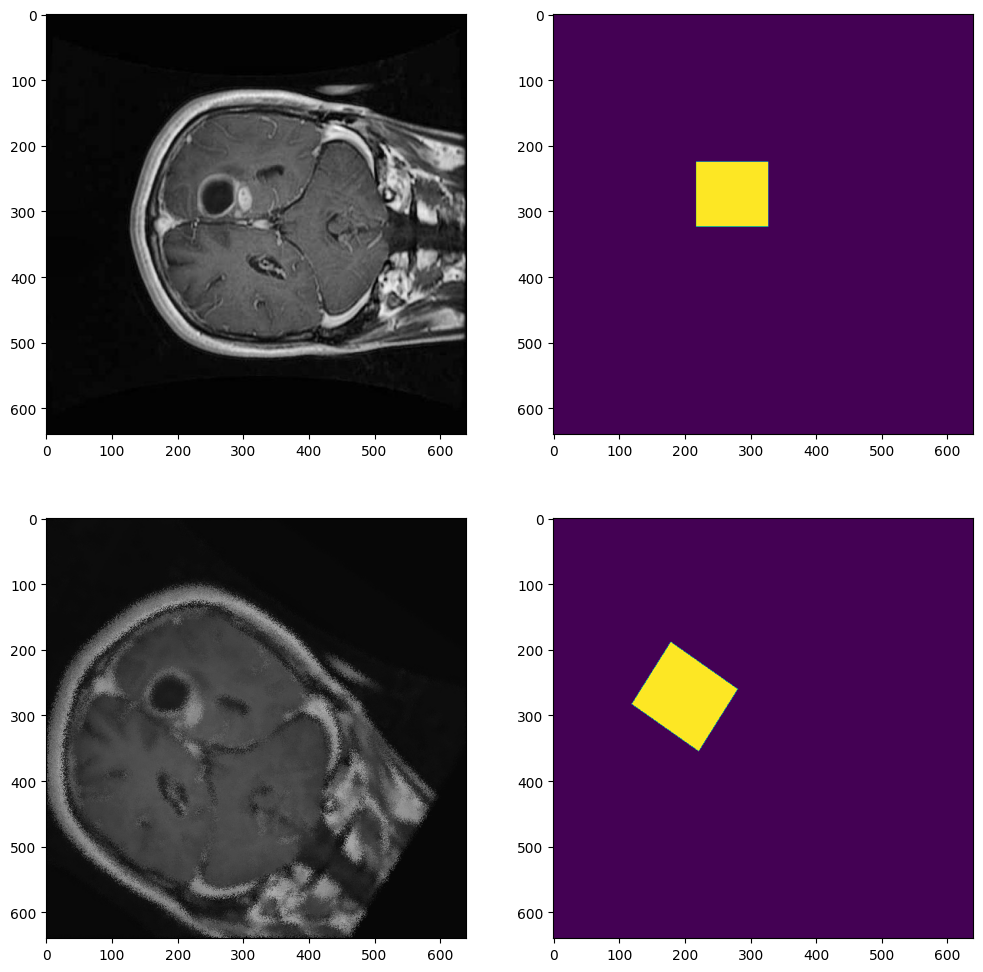

In [ ]:
from torchvision.transforms import v2
from PIL import Image
image, mask, image_orig, mask_orig = train_dataset.__getitem__(5)
fig, axes = plt.subplots (2,2,figsize=(12,12))
aug = v2.Compose([v2.RandomHorizontalFlip(p=0.5),
                 v2.RandomVerticalFlip(p=0.5),
                 v2.RandomAffine(degrees=(0, 70), translate=(0.2, 0.2), shear=(-10,10,-10,10), scale=(0.8, 1.2))
])

aug_img = v2.Compose([v2.ElasticTransform(alpha=10, sigma=0.08),
                     v2.ColorJitter(brightness=(0.1,1.0), contrast=(0.7,1.0), saturation=(0.7,1.0))])


axes[0][0].imshow(image_orig)
axes[0][1].imshow(mask_orig)
img_aug, mask_aug = aug(Image.fromarray(image_orig), Image.fromarray(mask_orig))
img_aug = aug_img(img_aug)
axes[1][0].imshow(img_aug)
axes[1][1].imshow(mask_aug)



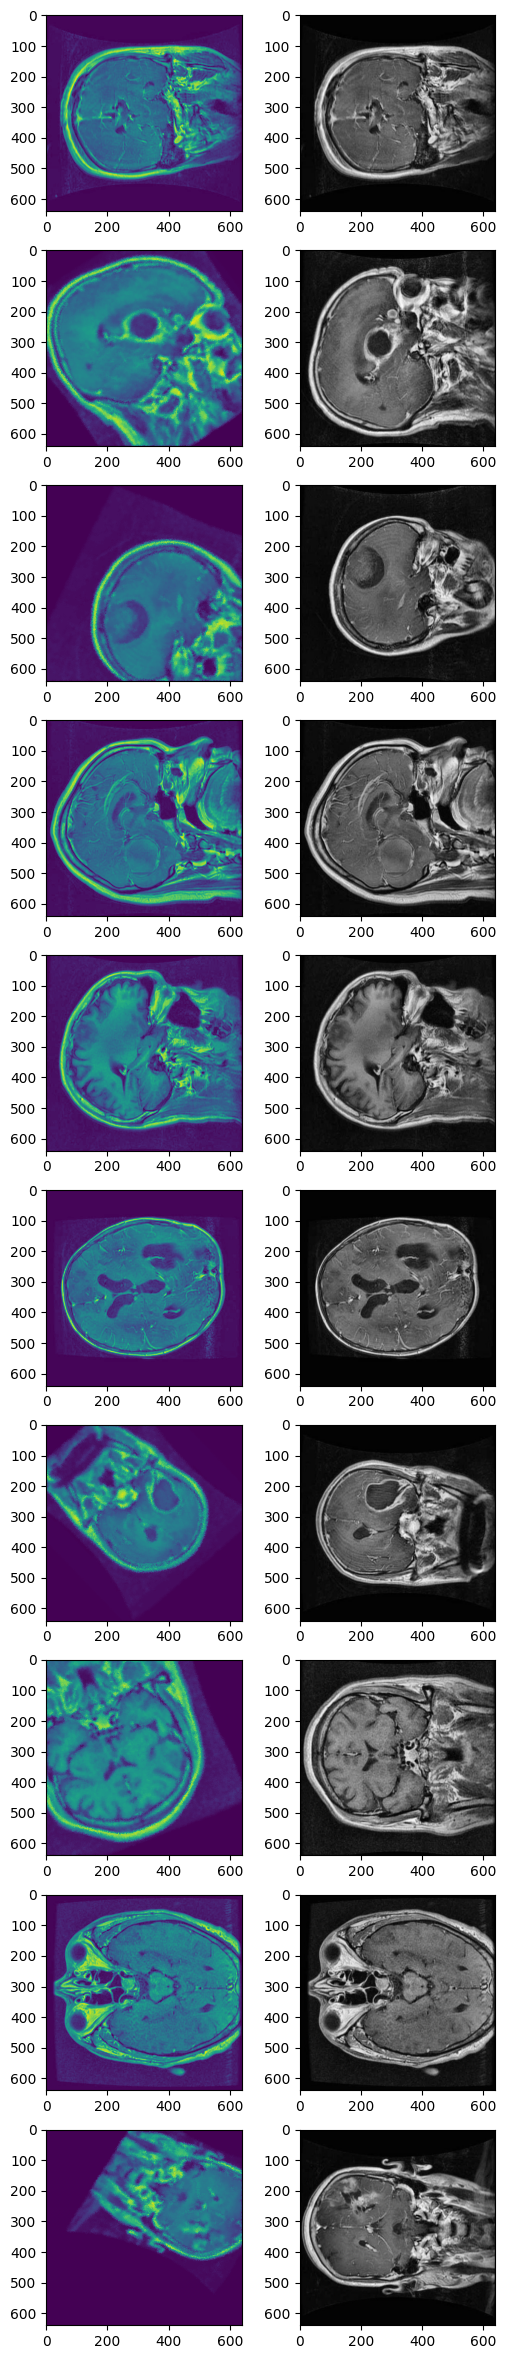

In [ ]:
fig, axes = plt.subplots (10,2,figsize=(6,30))

for i, (image, mask, image_orig, mask_orig) in enumerate(train_dataset):
  image, mask, image_orig, mask_orig = (image, mask, image_orig, mask_orig)
  if i < 10:
    axes[i][0].imshow(image[0])
    axes[i][1].imshow(image_orig)
  else:
    break

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Model Setting

In [ ]:
# Hyperparameters

num_epochs = 150
valid_step = 5
ckpt_step = 5
lr = 0.000001
exp_id = 'exp_31'

#resume_ckp = 'ckp_299.pt'
resume_ckp = None


# Initialize the model, loss function, and optimizer
model = ResNet2up_dialation()
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss.
#criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


## Training

In [ ]:
train(model,
      optimizer,
      criterion,
      num_epochs,
      train_loader,
      valid_loader,
      ckpt_step,
      valid_step,
      device,
      exp_id,
      resume_ckp = resume_ckp)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/150], Loss: 0.6111
Average Valid Loss: 0.6254
Epoch [2/150], Loss: 0.5975
Epoch [3/150], Loss: 0.5814
Epoch [4/150], Loss: 0.5635
Epoch [5/150], Loss: 0.5454
Epoch [6/150], Loss: 0.5285
Average Valid Loss: 0.5171
Epoch [7/150], Loss: 0.5128
Epoch [8/150], Loss: 0.4985
Epoch [9/150], Loss: 0.4855
Epoch [10/150], Loss: 0.4738
Epoch [11/150], Loss: 0.4632
Average Valid Loss: 0.4581
Epoch [12/150], Loss: 0.4538
Epoch [13/150], Loss: 0.4452
Epoch [14/150], Loss: 0.4375
Epoch [15/150], Loss: 0.4303
Epoch [16/150], Loss: 0.4237
Average Valid Loss: 0.4196
Epoch [17/150], Loss: 0.4174
Epoch [18/150], Loss: 0.4117
Epoch [19/150], Loss: 0.4062
Epoch [20/150], Loss: 0.4011
Epoch [21/150], Loss: 0.3962
Average Valid Loss: 0.3941
Epoch [22/150], Loss: 0.3915
Epoch [23/150], Loss: 0.3869
Epoch [24/150], Loss: 0.3825
Epoch [25/150], Loss: 0.3780
Epoch [26/150], Loss: 0.3739
Average Valid Loss: 0.3726
Epoch [27/150], Loss: 0.3696
Epoch [28/150], Loss: 0.3655
Epoch [29/150], Loss: 0.3614
Epoch 

In [ ]:
torch.cuda.empty_cache()

Text(0.5, 0.98, 'Training and Validation Loss Curves')

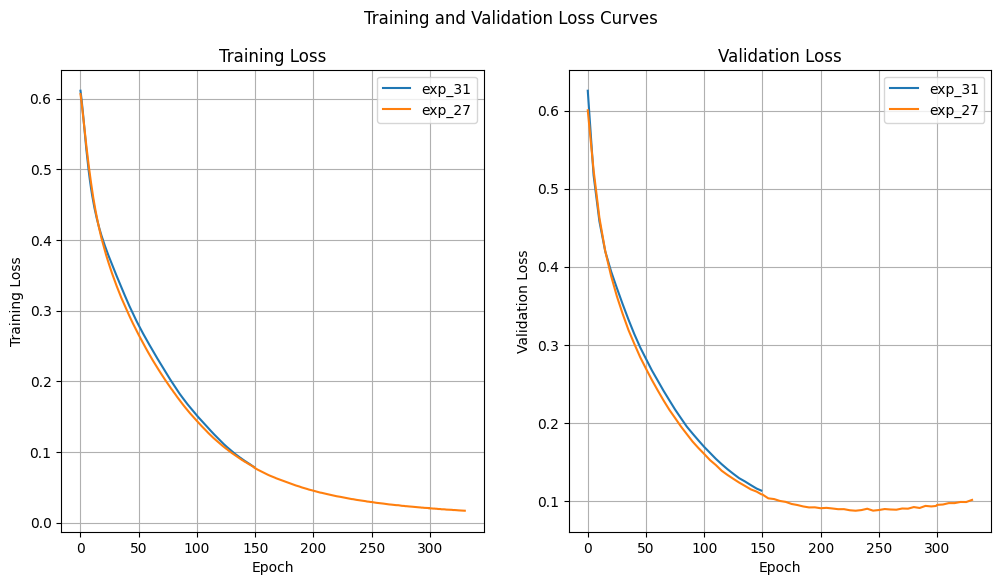

In [ ]:
"""
Plot train and validation curves
"""

exp_ids = ['exp_31','exp_27']
xlim_ = 5
ylim_ = 0.1

fig, axes = plt.subplots (1,2,figsize=(12,6))

for exp in exp_ids:

  in_path = os.path.join('Model_Checkpoints',exp,'loss_log.npy')
  loss_log = np.load(in_path, allow_pickle=True).item()
  train_loss = loss_log['train']
  valid_loss = loss_log['valid']

  axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1]) #vertically stack the array---- (train_loss) contains elements of [epoch, epoch_loss] --> 10 0utput because we have 10.
  axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])




#axes[0].set_xlim(0, xlim_)
#axes[1].set_xlim(0, xlim_)
#axes[0].set_ylim(0, ylim_)
#axes[1].set_ylim(0, ylim_)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[0].grid(True)
axes[1].grid(True)
axes[0].legend(exp_ids)
axes[1].legend(exp_ids)

fig.suptitle('Training and Validation Loss Curves')


In [ ]:
"""
Visualize sample validation result.
"""

#model = ResNetUNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idx= 40

experiments = ['exp_31']
ckps = ['ckp_149.pt']


img, mask, image_o, mask_o= valid_dataset.__getitem__(idx)


model = ResNet2up_dialation().to(device)

img = img.unsqueeze(0)
img = img.to(device)

preds = []
iou_val = []
acc_val = []
dice_val = []
prec_val = []
rec_val = []

for i, exp in enumerate(experiments):
  # Load the trained model
  ckp_path = os.path.join('Model_Checkpoints',exp, ckps[i])
  checkpoint = torch.load(ckp_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()
  sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid


  with torch.no_grad():
    pred = model(img)
  pred = pred.squeeze(0)
  pred = pred.squeeze(0)
  pred = sigmoid(pred).cpu().numpy()

  thresh=0.2
  pred[pred>thresh]=1.0
  pred[pred<=thresh]=0.0

  preds.append(pred)


  #iou_val.append(iou(mask, pred))
  #acc_val.append(accuracy(mask, pred))
  #dice_val.append(dice_coef(mask, pred))
  #prec_val.append(precision_score_(mask, pred))
  #rec_val.append(recall_score_(mask, pred))


# Plot the image, mask, and prediction
fig, axes = plt.subplots (1,4,figsize=(12,6))


#for exp in experiments:
 # print('{s} -- IoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}\n'.format(exp,iou_val,acc_val,dice_val,prec_val,rec_val))


axes[0].imshow(image_o)
axes[1].imshow(mask_o)
axes[2].imshow(preds[0])
#axes[3].imshow(preds[1])
#axes[4].imshow(preds[2])

for i in range(4):
  axes[i].axis('off')


NameError: name 'torch' is not defined

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model= ResNet2up_dialation().to(device)
# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_31','ckp_149.pt')

iou_val,acc_val,dice_val,prec_val,rec_val = evaluate(model, ckp_path, device, SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'valid'].reset_index(drop=True), subset='valid', outputsize = outputsize))

print('\nIoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


valid:  18%|█▊        | 79/429 [00:00<00:04, 85.87it/s]


Cannot read  19_jpg.rf.8e140bacd9c67bec022d7b62f31a274e.jpg


valid:  27%|██▋       | 114/429 [00:01<00:04, 77.99it/s]


Cannot read  1269_jpg.rf.9910a2b797a01f5f27e0af5c4f22316e.jpg


100%|██████████| 427/427 [00:05<00:00, 77.22it/s]


IoU:0.44, Acc:0.97, Dice:0.58, Precision:0.50, Recall:0.82


13/299-> IoU:0.34, Acc:0.97, Dice:0.44, Precision:0.58, Recall:0.45

14/299-> IoU:0.35, Acc:0.97, Dice:0.46, Precision:0.52, Recall:0.52

15/299-> IoU:0.37, Acc:0.97, Dice:0.49, Precision:0.59, Recall:0.50

16/90-> IoU:0.40, Acc:0.96, Dice:0.54, Precision:0.50, Recall:0.69


17/299 -> IoU:0.36, Acc:0.97, Dice:0.47, Precision:0.58, Recall:0.47

18/299 -> IoU:0.46, Acc:0.97, Dice:0.59, Precision:0.61, Recall:0.68

18/150 -> IoU:0.46, Acc:0.97, Dice:0.59, Precision:0.60, Recall:0.69


19/160 -> IoU:0.42, Acc:0.97, Dice:0.55, Precision:0.59, Recall:0.63



20/599 -> IoU:0.40, Acc:0.97, Dice:0.54, Precision:0.56, Recall:0.62

21/200 -> IoU:0.35, Acc:0.97, Dice:0.46, Precision:0.58, Recall:0.49

21/100 -> IoU:0.32, Acc:0.96, Dice:0.44, Precision:0.49, Recall:0.52

21/180 --> IoU:0.36, Acc:0.97, Dice:0.48, Precision:0.56, Recall:0.53

21/250 --> IoU:0.37, Acc:0.97, Dice:0.49, Precision:0.57, Recall:0.54

21/200 --> IoU:0.35, Acc:0.97, Dice:0.46, Precision:0.58, Recall:0.49

22/299 --> IoU:0.35, Acc:0.97, Dice:0.46, Precision:0.47, Recall:0.58

22/399 --> IoU:0.35, Acc:0.97, Dice:0.47, Precision:0.51, Recall:0.55

22/499 --> IoU:0.36, Acc:0.97, Dice:0.47, Precision:0.53, Recall:0.54

23/349 --> IoU:0.41, Acc:0.97, Dice:0.52, Precision:0.57, Recall:0.58

25/249 ---> IoU:0.49, Acc:0.98, Dice:0.61, Precision:0.62, Recall:0.71

25/299 --> IoU:0.49, Acc:0.98, Dice:0.61, Precision:0.64, Recall:0.69

26/299 --> IoU:0.49, Acc:0.97, Dice:0.62, Precision:0.58, Recall:0.79

27/299 --> IoU:0.50, Acc:0.97, Dice:0.63, Precision:0.59, Recall:0.78

30/235 -->  IoU:0.47, Acc:0.97, Dice:0.60, Precision:0.58, Recall:0.74





